In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib
import keras

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

2025-08-25 16:55:24.374104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 16:55:24.374743: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-25 16:55:24.377440: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-25 16:55:24.384094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756133724.396455   64471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756133724.39

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ronan/code/Power_Price_Forecasting/scripts/preprocess_att.py:709: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['datetime'].dt.to_period('M')


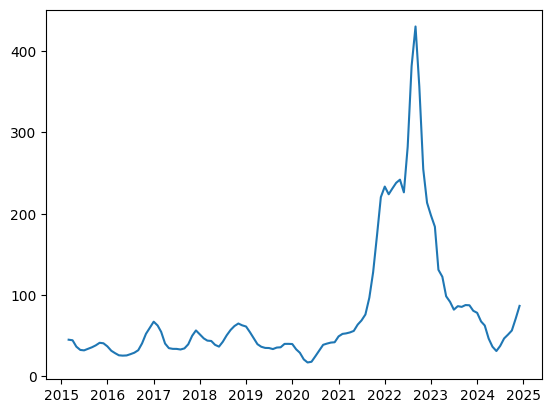

In [2]:
model_data = pd.read_csv(os.path.join(DATA_PATH, 'ATT', 'model_data.csv'))

from scripts.preprocess_att import monthly_statistics

monthly_stats = monthly_statistics(model_data)

plt.plot(monthly_stats.index, monthly_stats['3-Month Rolling Average'])

# 1. Import processed data

In [4]:
data_dir = os.path.join(DATA_PATH, 'ATT', 'classic')

X_past_train = np.load(os.path.join(data_dir, 'X_past_train.npy'))
X_future_train = np.load(os.path.join(data_dir, 'X_future_train.npy'))
X_past_val = np.load(os.path.join(data_dir, 'X_past_val.npy'))
X_future_val = np.load(os.path.join(data_dir, 'X_future_val.npy'))
X_past_test = np.load(os.path.join(data_dir, 'X_past_test.npy'))
X_future_test = np.load(os.path.join(data_dir, 'X_future_test.npy'))

X_past_train_transformed = np.load(os.path.join(data_dir, 'X_past_train_transformed.npy'))
X_future_train_transformed = np.load(os.path.join(data_dir, 'X_future_train_transformed.npy'))
X_past_val_transformed = np.load(os.path.join(data_dir, 'X_past_val_transformed.npy'))
X_future_val_transformed = np.load(os.path.join(data_dir, 'X_future_val_transformed.npy'))
X_past_test_transformed = np.load(os.path.join(data_dir, 'X_past_test_transformed.npy'))
X_future_test_transformed = np.load(os.path.join(data_dir, 'X_future_test_transformed.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

train_past_times = pd.read_pickle(os.path.join(data_dir, 'train_past_times.pkl'))
train_future_times = pd.read_pickle(os.path.join(data_dir, 'train_future_times.pkl'))

val_past_times = pd.read_pickle(os.path.join(data_dir, 'val_past_times.pkl'))
val_future_times = pd.read_pickle(os.path.join(data_dir, 'val_future_times.pkl'))
test_past_times = pd.read_pickle(os.path.join(data_dir, 'test_past_times.pkl'))
test_future_times = pd.read_pickle(os.path.join(data_dir, 'test_future_times.pkl'))



# 2. Forecast with simple LSTM

In [5]:
from scripts.model_lstm import LSTMModel

lstm_model = LSTMModel(
    # LSTM parameters
    lstm_units=32,        # Good starting point: ~2-4x number of features
    dense_units=16,        # Half of LSTM units for dimensionality reduction

    # Input dimensions (from your data)
    n_past_features=X_past_train_transformed.shape[2],
    n_future_features=X_future_train_transformed.shape[2],
    past_seq_len=X_past_train_transformed.shape[1],
    future_seq_len=X_future_train_transformed.shape[1],

    # Regularization
    dropout=0.3,           # Moderate dropout to prevent overfitting
    batch_normalization=True,

    # Training parameters
    learning_rate=0.001,   # Standard learning rate for Adam
    verbose=True,
    epochs_early_stopping=20,

    # Loss and metrics
    loss='mse',
    metrics=['mae', 'mape'],

    # Additional regularization
    regularization='l2',
    lambda_reg=0.01       # Small L2 penalty
)

lstm_model

2025-08-25 16:56:27.402248: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/1000


2025-08-25 16:57:06.372907: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 2059.0466 - mae: 41.0503 - mape: 97353.5391 - val_loss: 53642.2617 - val_mae: 200.5765 - val_mape: 501150.6875 - learning_rate: 0.0010
Epoch 2/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2031.4562 - mae: 41.1145 - mape: 409186.9688 - val_loss: 52809.9688 - val_mae: 198.7377 - val_mape: 2515834.5000 - learning_rate: 0.0010
Epoch 3/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2126.8433 - mae: 42.0741 - mape: 789856.5625 - val_loss: 51536.2891 - val_mae: 195.8047 - val_mape: 5802111.5000 - learning_rate: 0.0010
Epoch 4/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1928.1591 - mae: 41.0899 - mape: 575111.2500 - val_loss: 50218.1992 - val_mae: 192.6698 - val_mape: 9182491.0000 - learning_rate: 0.0010
Epoch 5/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1718.1436 - mae: 38.9973 - mape: 930242.0000 - val_loss: 48803.5078 - val_mae: 189.2868 - val_mape: 12099282.0000 - learning_rate: 0.0010
Epoch 6/1000
42/42 ━━━━━

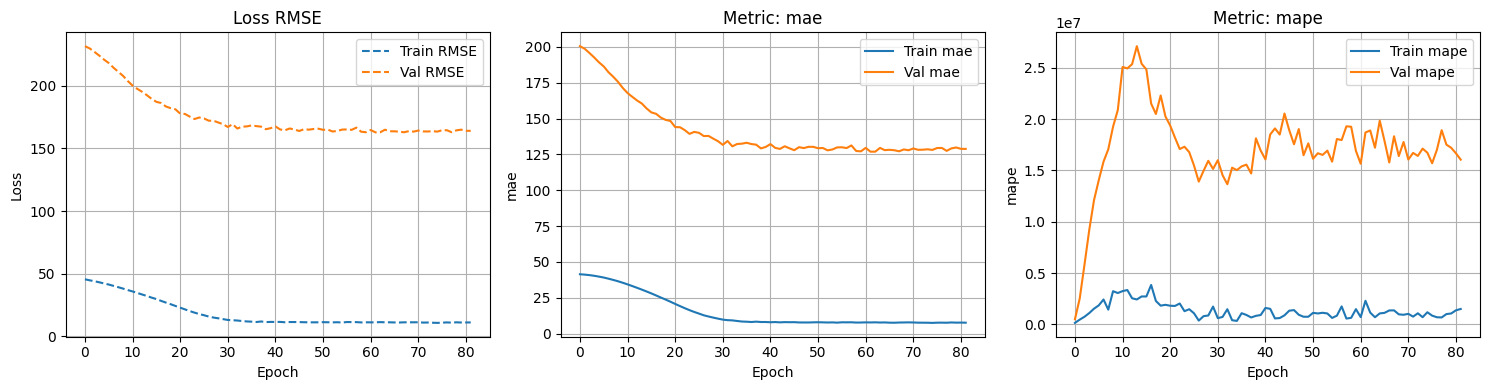

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21841.5195 - mae: 116.3592 - mape: 5430941.0000
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 47.3987 - mae: 3.6291 - mape: 261519.0000

Final Training Metrics:
RMSE: 6.9534
['mae', 'mape']: [3.830507278442383, 681258.9375]

Final Validation Metrics:
RMSE: 162.8191
['mae', 'mape']: [126.9493637084961, 18703364.0]


In [7]:
lstm_model.fit(X_past_train_transformed, X_future_train_transformed, y_train, 
            X_past_val_transformed, X_future_val_transformed, y_val)


In [ ]:
from scripts.config import LOGS_PATH
%tensorboard --logdir {LOGS_PATH}/LSTM/fit

Launching TensorBoard...

In [8]:
test_results = lstm_model.model.evaluate(
            [X_past_test, X_future_test],
            y_test
        )

test_loss = np.sqrt(test_results[0])
test_metrics = test_results[1:]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 162090745856.0000 - mae: 391606.6250 - mape: 4118015639552.0000
Test Loss: 410543.2140
Test Metrics: [400145.15625, 6004848721920.0]


In [ ]:
from scripts.model_att import AttentionModel
model_name = "20250820-135126"

att_model = AttentionModel.from_saved_model(model_name)

att_model

KeyError: 'parameters'

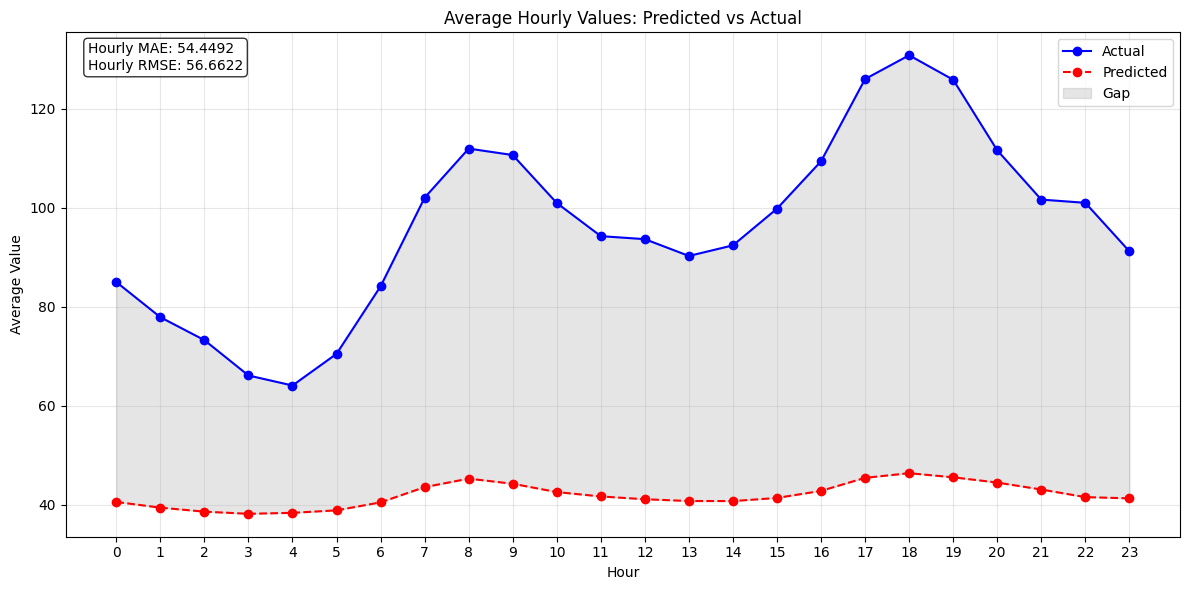

In [ ]:
pred = att_model.predict(X_past_test_transformed, X_future_test_transformed)

att_model.plot_hourly_averages(y_test, pred)

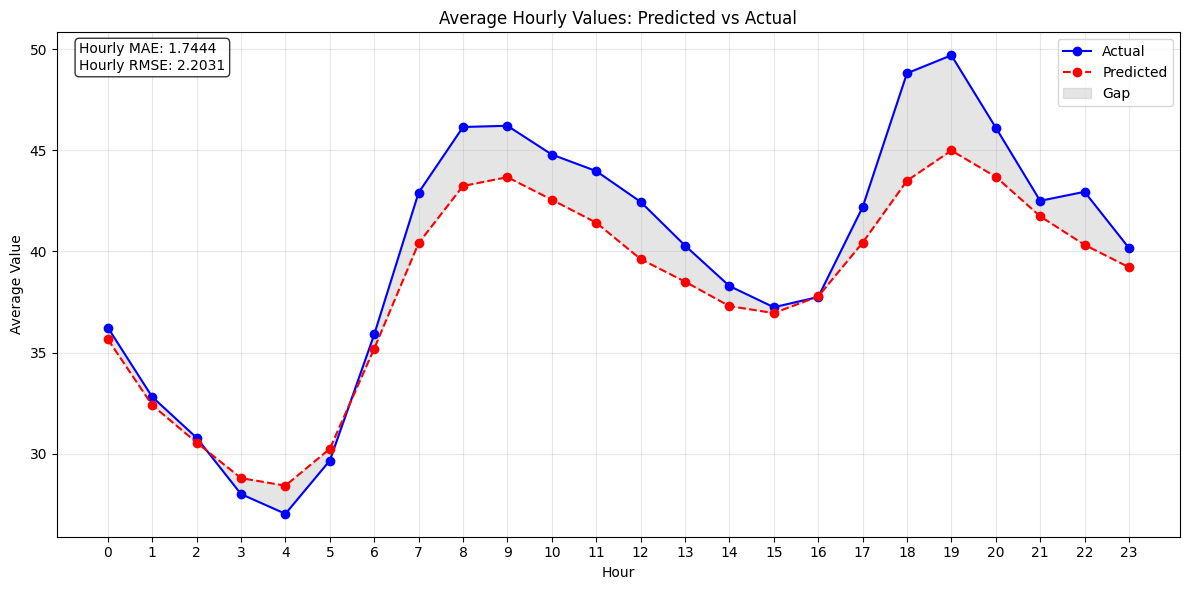

In [ ]:
pred = att_model.predict(X_past_train_transformed, X_future_train_transformed)

att_model.plot_hourly_averages(y_train, pred)